# Cross-validation leaderboard

Goal is to build and compare models using clean data.

In [17]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score, balanced_accuracy_score
import pandas as pd
from src.utils import load_cleaned_data

1. Load cleaned data
2. Define models and vectorizers (NB, LR, RF, XGBoost)

In [18]:
df = load_cleaned_data("data/byarticle_clean.tsv")
X, y = df["full_text"], df["label"]

model_configs = [
    ("Naive Bayes + CountVec", CountVectorizer(max_features=10000, stop_words="english"), MultinomialNB()),
    ("LogReg + TF-IDF", TfidfVectorizer(max_features=10000, stop_words="english"), LogisticRegression(max_iter=1000)),
    ("RandomForest + TF-IDF", TfidfVectorizer(max_features=10000, stop_words="english"), RandomForestClassifier(n_estimators=100)),
    ("XGBoost + TF-IDF", TfidfVectorizer(max_features=10000, stop_words="english"), XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
]

Set up scorers & stratisfied CV

In [19]:

scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up results
Pipelines, evaluation, result tables

In [20]:
results = []

for name, vectorizer, model in model_configs:
    pipeline = ImbPipeline([
        ('vect', vectorizer),
        ('ros', RandomOverSampler(random_state=0)),
        ('clf', model)
    ])

    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

    results.append({
        'Model': name,
        'F1 (avg)': scores['test_f1'].mean(),
        'Precision (avg)': scores['test_precision'].mean(),
        'Recall (avg)': scores['test_recall'].mean(),
        'Balanced Acc (avg)': scores['test_balanced_accuracy'].mean(),
        'ROC AUC (avg)': scores['test_roc_auc'].mean()
    })


# Display

In [21]:
results_df = pd.DataFrame(results).round(3)
print("\n=== Model Comparison (5-fold CV) ===")
print(results_df)


=== Model Comparison (5-fold CV) ===
                    Model  F1 (avg)  Precision (avg)  Recall (avg)  \
0  Naive Bayes + CountVec     0.692            0.635         0.760   
1         LogReg + TF-IDF     0.684            0.693         0.677   
2   RandomForest + TF-IDF     0.650            0.723         0.597   
3        XGBoost + TF-IDF     0.678            0.731         0.634   

   Balanced Acc (avg)  ROC AUC (avg)  
0               0.752          0.808  
1               0.750          0.841  
2               0.731          0.831  
3               0.749          0.833  


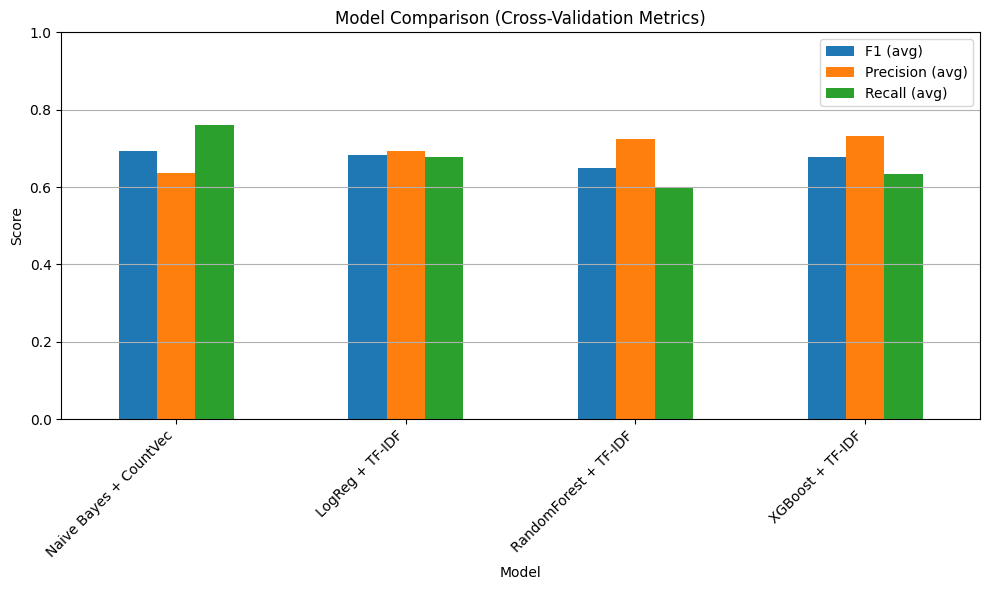

In [22]:
# Bar Chart

import matplotlib.pyplot as plt

# Assume 'results_df' is your DataFrame from earlier
metrics_to_plot = ['F1 (avg)', 'Precision (avg)', 'Recall (avg)']

results_df.set_index('Model')[metrics_to_plot].plot(kind='bar', figsize=(10,6))
plt.title('Model Comparison (Cross-Validation Metrics)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
